In [105]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
import scipy.stats as ss
from imblearn.over_sampling import SMOTE
from get_data import get_data_from_snowflake
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import PCA
# make an ROC AUC curve on the graph
from sklearn.metrics import roc_curve, roc_auc_score,auc
from matplotlib import pyplot as plt

In [2]:
from get_train_test import get_train_test_data 
equifax_data, arro_data = get_train_test_data()

In [3]:
final_features = ['COUNT_NEG_BAL_OCC_0_180','NUM_INQ_24M','TOT_HIGH_CREDIT_OPEN_REVOLVING','TOTAL_BALANCE','PCT_BANKCARD_TO_TOT_TRADES',
'SUM_INSURANCE_EXPENSE_TXN','TOT_UTIL_BANKCARD_TRADES','TOT_HIGH_CREDIT_OPEN_BANKCARD','COUNT_ASSET_DEPOSIT_TXN','TOT_PAST_DUE_BAL',
'AGE_NEWEST_BANKCARD_TRADE','TOT_LOAN_AMT_OPEN_INSTALLMENT','AVG_SALARY_INCOME_TXN','PCT_TRADES_OPENED_12M_TO_TOT_TRADES','AGE_NEWEST_TRADE',
'NUM_TRADES_WORST_EVER_60PLUSD_PAST_DUE','SUM_CASH_OUTFLOW_TRANSFERS','AGE_OLDEST_BANKCARD_TRADE','COUNT_NEG_BAL_OCC_0_30',
'SUM_UTILITIES_EXPENSE_TXN','AVG_UTILITIES_EXPENSE_TXN','COUNT_TELECOM_EXPENSE_TXN_0_30','SUM_SALARY_INCOME_TXN_0_365',
'TOT_BAL_REVOLVING_TRADES','NUM_OPEN_BANKCARD_TRADES_UTIL_GTE_75PCT','PCT_REVOLVING_TRADES_GOOD_6M_TO_REVOLVING_TRADES_6M']

# Downsampled equifax and upsampled Arro

#### Making the test set

In [4]:
from get_testing_data import get_test_data
arro_test = get_test_data()

In [5]:
# make a test set
test_set = equifax_data[final_features].sample(frac=0.01, random_state=42)
full_test_set = pd.concat([test_set, arro_test[final_features]])
target_test = np.concatenate([np.zeros(len(test_set[final_features])), np.ones(len(arro_test[final_features]))])
# combine full_test_set and target_test
full_test_set['Target'] = target_test

In [6]:
# remove the test set from equifax_data
equifax_train_data = equifax_data[final_features].drop(test_set.index)
combined_data_features_selected = pd.concat([equifax_train_data[final_features], arro_data[final_features]], ignore_index=True)
target_features_selected = np.concatenate([np.zeros(len(equifax_train_data[final_features])), np.ones(len(arro_data[final_features]))])

#### Upsampling arro and downsampling equifax

In [7]:
# upsample arro_data
smote_upsampled = SMOTE(sampling_strategy=5000/len(equifax_train_data),random_state=42)
combined_data_upsampled, target_upsampled = smote_upsampled.fit_resample(combined_data_features_selected, target_features_selected)

full_data_upsampled = pd.concat([combined_data_upsampled, pd.DataFrame(target_upsampled)], axis=1)
full_data_upsampled.rename(columns={0: 'Target'}, inplace=True)

equifax_data_upsampled = full_data_upsampled[full_data_upsampled['Target'] == 0]
arro_data_upsampled = full_data_upsampled[full_data_upsampled['Target'] == 1]

# bootstrap arro
bootstrapped_arro_data = arro_data_upsampled.sample(n=50000, replace=True,random_state=42)

# downsample equifax 
desired_sample_size = 50000
fraction_to_sample = desired_sample_size / len(equifax_train_data)
downsampled_equifax_data = equifax_train_data[final_features].sample(frac=fraction_to_sample, random_state=42)  # set random seed for reproducibility

In [8]:
# make dataset
combined_data_whole = pd.concat([downsampled_equifax_data[final_features], bootstrapped_arro_data[final_features]], ignore_index=True)
print(combined_data_whole.shape)
# Create the target variable (0 for train, 1 for company_data)
target_whole = np.concatenate([np.zeros(len(downsampled_equifax_data[final_features])), np.ones(len(bootstrapped_arro_data[final_features]))])
print(target_whole.shape)

(100000, 26)
(100000,)


In [186]:
def run_probit_model(X_train, y_train, full_test_set):
    X = sm.add_constant(X_train)  # Add a constant column for the intercept
    # Fit the probit model
    model = sm.Probit(y_train, X)
    result_whole = model.fit(method='bfgs', maxiter=100)
    # predict on test set
    X_test = sm.add_constant(full_test_set.drop('Target', axis=1))
    y_pred = result_whole.predict(X_test)
    y_pred = pd.DataFrame(y_pred)
    y_pred.rename(columns={0: 'pred'}, inplace=True)
    # get the threshold
    threshold = 0.5
    y_pred['pred'] = np.where(y_pred['pred'] > threshold, 1, 0)
    y_pred['Target'] = target_test
    y_pred['correct'] = np.where(y_pred['pred'] == y_pred['Target'], 1, 0)
    print("Accuracy",y_pred['correct'].sum() / len(y_pred))
    print("Confusion matrix \n",confusion_matrix(y_pred['Target'].to_numpy(), y_pred['pred'].to_numpy()))
    print(classification_report(y_pred['Target'], y_pred['pred']))
    fpr, tpr, _ = roc_curve(full_test_set['Target'],result_whole.predict(X_test))
    area = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',lw=3,label='ROC curve (AUC = %0.5f)' % area)
    plt.plot([0, 1], [0, 1], color='blue', lw=3, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.10])
    plt.legend(loc="lower right")
    return result_whole.predict(X_test)

# Model 4

Optimization terminated successfully.
         Current function value: 0.179798
         Iterations: 25
         Function evaluations: 12431
Accuracy 0.9408198614318707
Confusion matrix 
 [[3119  193]
 [  12  140]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      3312
         1.0       0.42      0.92      0.58       152

    accuracy                           0.94      3464
   macro avg       0.71      0.93      0.77      3464
weighted avg       0.97      0.94      0.95      3464



/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


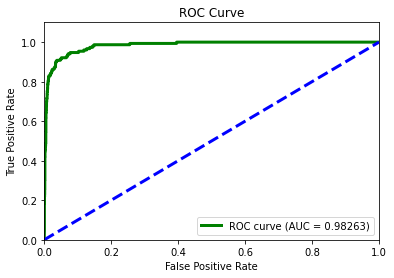

In [185]:
probability_values = run_probit_model(combined_data_whole, target_whole, full_test_set)

In [36]:
# count where probability_values is 1
print(len(probability_values[probability_values > 0.5]))

335


# Standardized version

In [108]:
def get_standardized_data(train_data, test_data):
    def make_mean_std(df : pd.DataFrame):
        mean = df.mean()
        std = df.std()
        def _standardize(this_df : pd.DataFrame) -> pd.DataFrame:
            return (this_df - mean) / std
        return _standardize
    standardized_fn = make_mean_std(train_data)
    standardized_train = standardized_fn(train_data)
    standardized_test = standardized_fn(test_data)
    combined_data = pd.concat([standardized_train, standardized_test], ignore_index=True)
    # Create the target variable (0 for train, 1 for company_data)
    target = np.concatenate([np.zeros(len(standardized_train)), np.ones(len(standardized_test))])
    return combined_data, target, standardized_fn

In [109]:
standardised_data, standardised_target, standardized_fn = get_standardized_data(downsampled_equifax_data[final_features], bootstrapped_arro_data[final_features])

In [110]:
full_test_set_standardized = standardized_fn(full_test_set.drop('Target', axis=1))
full_test_set_standardized['Target'] = target_test

# Model 5

         Current function value: 0.180134
         Iterations: 73
         Function evaluations: 136
         Gradient evaluations: 124
Accuracy 0.9393764434180139
Confusion matrix 
 [[3115  197]
 [  13  139]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      3312
         1.0       0.41      0.91      0.57       152

    accuracy                           0.94      3464
   macro avg       0.70      0.93      0.77      3464
weighted avg       0.97      0.94      0.95      3464



/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


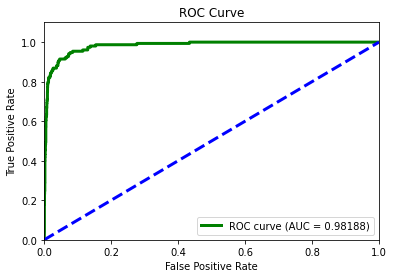

In [111]:
probability_values = run_probit_model(standardised_data, standardised_target, full_test_set_standardized)

# Model 1

# Simple Probit model (no upsampling/downsampling)

In [70]:
simple_equifax_data = equifax_data.sample(frac=0.01, random_state=42)
simple_test = pd.concat([simple_equifax_data, arro_test])
simple_target_test = np.concatenate([np.zeros(len(simple_equifax_data)), np.ones(len(arro_test))])
simple_test['Target'] = simple_target_test

In [71]:
simple_combined_data = pd.concat([equifax_data.drop(test_set.index), arro_data])
simple_target = np.concatenate([np.zeros(len(equifax_data.drop(test_set.index))), np.ones(len(arro_data))])

Optimization terminated successfully.
         Current function value: 0.419657
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10
Accuracy 0.9561200923787528
Confusion matrix 
 [[3312    0]
 [ 152    0]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3312
         1.0       0.00      0.00      0.00       152

    accuracy                           0.96      3464
   macro avg       0.48      0.50      0.49      3464
weighted avg       0.91      0.96      0.93      3464



/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and

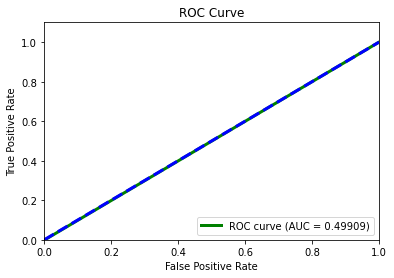

In [114]:
prob_simple_values = run_probit_model(simple_combined_data, simple_target, simple_test)

In [75]:
# probit cant handle imbalanced data
prob_simple_values.value_counts()

0.000000e+00     3458
9.850919e-135       1
7.312883e-95        1
1.824598e-90        1
1.824652e-247       1
4.537859e-176       1
9.850914e-135       1
dtype: int64

# Selected features

In [163]:
some_feautres = ['COUNT_NEG_BAL_OCC_0_180',
 'NUM_INQ_24M',
 'TOT_HIGH_CREDIT_OPEN_REVOLVING',
 'TOTAL_BALANCE',
 'PCT_BANKCARD_TO_TOT_TRADES',
 'SUM_INSURANCE_EXPENSE_TXN',
 'TOT_UTIL_BANKCARD_TRADES',
 'TOT_HIGH_CREDIT_OPEN_BANKCARD',
 'COUNT_ASSET_DEPOSIT_TXN',
 'TOT_PAST_DUE_BAL',
 'AGE_NEWEST_BANKCARD_TRADE',
 'TOT_LOAN_AMT_OPEN_INSTALLMENT',
 'AVG_SALARY_INCOME_TXN',
 'PCT_TRADES_OPENED_12M_TO_TOT_TRADES',
 'AGE_NEWEST_TRADE',
 'NUM_TRADES_WORST_EVER_60PLUSD_PAST_DUE',
 'SUM_CASH_OUTFLOW_TRANSFERS',
 'AGE_OLDEST_BANKCARD_TRADE',
 'COUNT_NEG_BAL_OCC_0_30',
 'SUM_UTILITIES_EXPENSE_TXN',
 'AVG_UTILITIES_EXPENSE_TXN',
 'COUNT_TELECOM_EXPENSE_TXN_0_30',
 'SUM_SALARY_INCOME_TXN_0_365',
 'TOT_BAL_REVOLVING_TRADES',
 'NUM_OPEN_BANKCARD_TRADES_UTIL_GTE_75PCT',
 'PCT_REVOLVING_TRADES_GOOD_6M_TO_REVOLVING_TRADES_6M','Target']

# Model 3

Optimization terminated successfully.
         Current function value: 0.419657
         Iterations: 2
         Function evaluations: 10
         Gradient evaluations: 10
Accuracy 0.9561200923787528
Confusion matrix 
 [[3312    0]
 [ 152    0]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3312
         1.0       0.00      0.00      0.00       152

    accuracy                           0.96      3464
   macro avg       0.48      0.50      0.49      3464
weighted avg       0.91      0.96      0.93      3464



/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: divide by zero encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2874: RuntimeWarning: invalid value encountered in multiply
  return np.dot(-L*(L+XB)*X.T,X)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-package

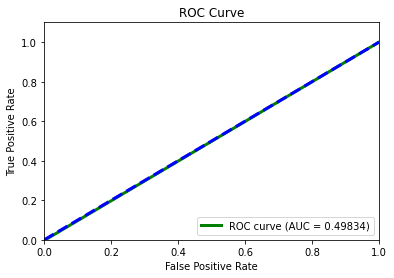

In [165]:
prob_simple_values = run_probit_model(simple_combined_data[final_features], simple_target, simple_test[some_feautres])

## Upsampled and downsampled for all features

In [133]:
len(equifax_data.drop(test_set.index))

327839

In [136]:
# upsample arro_data
smote_upsampled_simple = SMOTE(sampling_strategy=5000/len(equifax_data.drop(test_set.index)),random_state=42)
combined_data_upsampled_simple, target_upsampled_simple = smote_upsampled_simple.fit_resample(simple_combined_data, simple_target)

simple_full_data_upsampled = pd.concat([combined_data_upsampled_simple, pd.DataFrame(target_upsampled_simple)], axis=1)
simple_full_data_upsampled.rename(columns={0: 'Target'}, inplace=True)

simple_arro_data_upsampled = simple_full_data_upsampled[simple_full_data_upsampled['Target'] == 1]

# bootstrap arro
simple_bootstrapped_arro_data = simple_arro_data_upsampled.sample(n=50000, replace=True,random_state=42)

# downsample equifax 
desired_sample_size = 50000
fraction_to_sample = desired_sample_size / len(equifax_data.drop(test_set.index))
simple_downsampled_equifax_data = equifax_data.drop(test_set.index).sample(frac=fraction_to_sample, random_state=42)  # set random seed for reproducibility

In [141]:
# make dataset
simple_combined_data_whole = pd.concat([simple_downsampled_equifax_data, simple_bootstrapped_arro_data.drop(columns={'Target'})], ignore_index=True)
print(simple_combined_data_whole.shape)
# Create the target variable (0 for train, 1 for company_data)
simple_target_whole = np.concatenate([np.zeros(len(simple_downsampled_equifax_data)), np.ones(len(simple_bootstrapped_arro_data))])
print(simple_target_whole.shape)

(100000, 45)
(100000,)


# Model 2

         Current function value: 0.169391
         Iterations: 105
         Function evaluations: 123
         Gradient evaluations: 123
Accuracy 0.9422632794457275
Confusion matrix 
 [[3125  187]
 [  13  139]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      3312
         1.0       0.43      0.91      0.58       152

    accuracy                           0.94      3464
   macro avg       0.71      0.93      0.78      3464
weighted avg       0.97      0.94      0.95      3464



/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


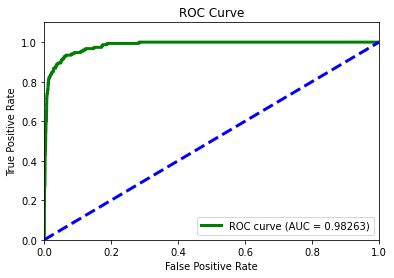

In [145]:
prob_simple_values = run_probit_model(simple_combined_data_whole, simple_target_whole, simple_test)

## PCA inputs for Probit model

In [83]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(combined_data_whole)
X_train_pca = pd.DataFrame({'PC1': X_train_pca[:, 0], 'PC2': X_train_pca[:, 1], 'PC3': X_train_pca[:, 2]})
X_test_pca = pca.transform(full_test_set.drop('Target', axis=1))
X_test_pca = pd.DataFrame({'PC1': X_test_pca[:, 0], 'PC2': X_test_pca[:, 1], 'PC3': X_test_pca[:, 2], 'Target': target_test})

# Model 6

         Current function value: 0.467053
         Iterations: 11
         Function evaluations: 77
         Gradient evaluations: 65
Accuracy 0.7040993071593533
Confusion matrix 
 [[2294 1018]
 [   7  145]]
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82      3312
         1.0       0.12      0.95      0.22       152

    accuracy                           0.70      3464
   macro avg       0.56      0.82      0.52      3464
weighted avg       0.96      0.70      0.79      3464



/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


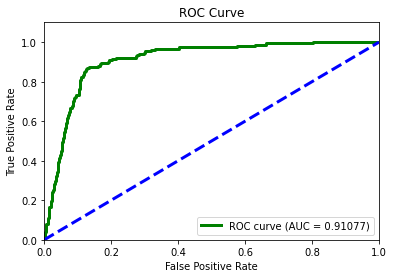

In [115]:
pca_prob_values = run_probit_model(X_train_pca, target_whole, X_test_pca)

# Model 7

# Regularization with Probit

In [187]:
def run_regularized_probit_model(X_train, y_train, full_test_set):
    X = sm.add_constant(X_train)  # Add a constant column for the intercept
    # Fit the probit model
    model = sm.Probit(y_train, X)
    # Fit the model using a regularized maximum likelihood.
    result_whole = model.fit_regularized()
    # predict on test set
    X_test = sm.add_constant(full_test_set.drop('Target', axis=1))
    y_pred = result_whole.predict(X_test)
    y_pred = pd.DataFrame(y_pred)
    y_pred.rename(columns={0: 'pred'}, inplace=True)
    # get the threshold
    threshold = 0.5
    y_pred['pred'] = np.where(y_pred['pred'] > threshold, 1, 0)
    y_pred['Target'] = target_test
    y_pred['correct'] = np.where(y_pred['pred'] == y_pred['Target'], 1, 0)
    print("Accuracy",y_pred['correct'].sum() / len(y_pred))
    print("Confusion matrix \n",confusion_matrix(y_pred['Target'].to_numpy(), y_pred['pred'].to_numpy()))
    print(classification_report(y_pred['Target'], y_pred['pred']))
    fpr, tpr, _ = roc_curve(full_test_set['Target'],result_whole.predict(X_test))
    area = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='green',lw=3,label='ROC curve (AUC = %0.5f)' % area)
    plt.plot([0, 1], [0, 1], color='blue', lw=3, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.10])
    plt.legend(loc="lower right")
    return result_whole.predict(X_test)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 18.025431059897485
            Iterations: 2
            Function evaluations: 12
            Gradient evaluations: 2
Accuracy 0.9561200923787528
Confusion matrix 
 [[3312    0]
 [ 152    0]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3312
         1.0       0.00      0.00      0.00       152

    accuracy                           0.96      3464
   macro avg       0.48      0.50      0.49      3464
weighted avg       0.91      0.96      0.93      3464

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:               100000
Model:                         Probit   Df Residuals:                    99973
Method:                           MLE   Df Model:                           26
Date:                Thu, 12 Oct 2023   Pseudo R-squ.:                  -25

/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2873: RuntimeWarning: invalid value encountered in divide
  L = q*self.pdf(q*XB)/self.cdf(q*XB)
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vedaantibaliga/opt/anaconda3/envs/snowpark-de-ml/lib/python3.9

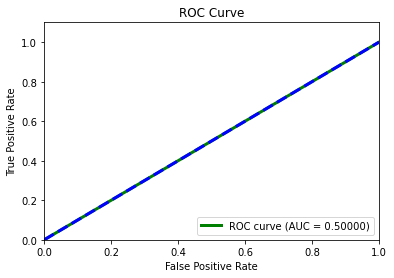

In [188]:
probability_values_regularized = run_regularized_probit_model(combined_data_whole, target_whole, full_test_set)

# Doesn't work

1. Make notes on what probit works
2. Advantages and disadvantages
3. Write about what you have done till now
4. Try to show the graphs used


In [174]:
['COUNT_NEG_BAL_OCC_0_180','NUM_INQ_24M','TOT_HIGH_CREDIT_OPEN_REVOLVING','TOTAL_BALANCE','PCT_BANKCARD_TO_TOT_TRADES','SUM_INSURANCE_EXPENSE_TXN',
'TOT_UTIL_BANKCARD_TRADES','TOT_HIGH_CREDIT_OPEN_BANKCARD','COUNT_ASSET_DEPOSIT_TXN','TOT_PAST_DUE_BAL','AGE_NEWEST_BANKCARD_TRADE','TOT_LOAN_AMT_OPEN_INSTALLMENT',
'AVG_SALARY_INCOME_TXN','PCT_TRADES_OPENED_12M_TO_TOT_TRADES','AGE_NEWEST_TRADE','NUM_TRADES_WORST_EVER_60PLUSD_PAST_DUE','SUM_CASH_OUTFLOW_TRANSFERS',
'AGE_OLDEST_BANKCARD_TRADE','COUNT_NEG_BAL_OCC_0_30','SUM_UTILITIES_EXPENSE_TXN','AVG_UTILITIES_EXPENSE_TXN','COUNT_TELECOM_EXPENSE_TXN_0_30','SUM_SALARY_INCOME_TXN_0_365',
'TOT_BAL_REVOLVING_TRADES','NUM_OPEN_BANKCARD_TRADES_UTIL_GTE_75PCT','PCT_REVOLVING_TRADES_GOOD_6M_TO_REVOLVING_TRADES_6M']